# Train AE model to have committor as encoder

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

Imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from potentials.MullerBrown import MullerBrown
from simulations.UnbiasedMD import OverdampedLangevin

### Generate dataset with Boltzmann-Gibbs initial distribution of points. 

In [4]:
pot = MullerBrown()

In [5]:
beta = 0.05
dt = 0.0001
unbiased_OL_on_MB = OverdampedLangevin(pot, beta, dt=dt)
x_0 = pot.minP
n_steps = 2* 10**5

In [9]:
traj_dict = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=True)

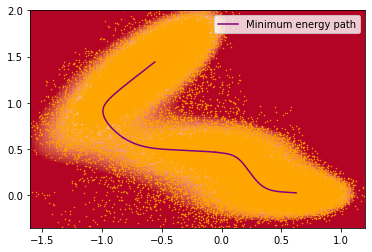

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ax.scatter(traj_dict["x_traj"][:, 0], traj_dict["x_traj"][:, 1], marker=".", color="orange", s=1)
ax.legend()

In [11]:
K = 5 * 10**2 # number of short trajectories 
N = 160 # time lagg in number of delta t
max_epochs = 10000

In [12]:
ini_index = np.random.choice(n_steps - N, size=2*K)
#print(ini_index)
#print(ini_index+1)

Gather the training dataset (stop the trajectories when R or P is reached (zeros gaussian and constant position to keep constant array shape))


In [13]:
j = 0
if pot.in_P(traj_dict["x_traj"][ini_index[j]]) or pot.in_R(traj_dict["x_traj"][ini_index[j]]):
    x_beg = None
else:
    x_beg = traj_dict["x_traj"][ini_index[j]:ini_index[j]+1]
x_end = None
dataset = np.append(traj_dict["x_traj"][ini_index[j]:ini_index[j]+1], traj_dict["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
dataset = np.append(dataset, traj_dict["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)
if (pot.in_P(traj_dict["x_traj"][ini_index[j]+1]) or pot.in_R(traj_dict["x_traj"][ini_index[j]+1])) and x_beg is not None:
    x_end = traj_dict["x_traj"][ini_index[j]+1:ini_index[j]+2]
for i in range(1, N):
    if x_end is not None:
        dataset = np.append(dataset, np.zeros([1, 2]), axis=1)
        dataset = np.append(dataset, x_end, axis=1)
    else:
        dataset = np.append(dataset, traj_dict["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
        dataset = np.append(dataset, traj_dict["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
        if (pot.in_P(traj_dict["x_traj"][ini_index[j]+1+i]) or pot.in_R(traj_dict["x_traj"][ini_index[j]+1+i])) and x_beg is not None:
            x_end = traj_dict["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2]
        elif not (pot.in_P(traj_dict["x_traj"][ini_index[j]+1+i]) or pot.in_R(traj_dict["x_traj"][ini_index[j]+1+i])): 
            x_beg = traj_dict["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2]
for j in range(1, 2*K):
    if pot.in_P(traj_dict["x_traj"][ini_index[j]]) or pot.in_R(traj_dict["x_traj"][ini_index[j]]):
        x_beg = None
    else:
        x_beg = traj_dict["x_traj"][ini_index[j]:ini_index[j]+1]
    x_end = None
    datapoint = np.append(traj_dict["x_traj"][ini_index[j]:ini_index[j]+1], traj_dict["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
    datapoint = np.append(datapoint, traj_dict["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)
    if (pot.in_P(traj_dict["x_traj"][ini_index[j]+1]) or pot.in_R(traj_dict["x_traj"][ini_index[j]+1])) and x_beg is not None:
        x_end = traj_dict["x_traj"][ini_index[j]+1:ini_index[j]+2]
    for i in range(1, N):
        if x_end is not None:
            datapoint = np.append(datapoint, np.zeros([1, 2]), axis=1)
            datapoint = np.append(datapoint, x_end, axis=1)
        else:
            datapoint = np.append(datapoint, traj_dict["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
            datapoint = np.append(datapoint, traj_dict["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
            if (pot.in_P(traj_dict["x_traj"][ini_index[j]+1+i]) or pot.in_R(traj_dict["x_traj"][ini_index[j]+1+i])) and x_beg is not None:
                x_end = traj_dict["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2]
            elif not (pot.in_P(traj_dict["x_traj"][ini_index[j]+1+i]) or pot.in_R(traj_dict["x_traj"][ini_index[j]+1+i])): 
                x_beg = traj_dict["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2]
    dataset = np.append(dataset, datapoint, axis=0)
print(dataset.shape)
        
dataset = {"any_distrib" : dataset, "beta" : beta, "dt" : dt}
dataset.keys()

(1000, 642)


dict_keys(['any_distrib', 'beta', 'dt'])

Generate dataset in which the trajectory is not stopped once R or P is reached

In [14]:
j = 0

dataset = np.append(traj_dict["x_traj"][ini_index[j]:ini_index[j]+1], traj_dict["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
dataset = np.append(dataset, traj_dict["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)
for i in range(1, N):
    dataset = np.append(dataset, traj_dict["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
    dataset = np.append(dataset, traj_dict["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
for j in range(1, 2*K):
    datapoint = np.append(traj_dict["x_traj"][ini_index[j]:ini_index[j]+1], traj_dict["gauss_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)    
    datapoint = np.append(datapoint, traj_dict["x_traj"][ini_index[j]+1:ini_index[j]+2], axis=1)
    for i in range(1, N):
        datapoint = np.append(datapoint, traj_dict["gauss_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)
        datapoint = np.append(datapoint, traj_dict["x_traj"][ini_index[j]+1+i:ini_index[j]+i+2], axis=1)

    dataset = np.append(dataset, datapoint, axis=0)
print(dataset.shape)
        
dataset = {"any_distrib" : dataset, "beta" : beta, "dt" : dt}
dataset.keys()

(1000, 642)


dict_keys(['any_distrib', 'beta', 'dt'])

Import class for committor AE model and its training

In [15]:
from committor.neural_net_models import CommittorOneDecoder
from committor.train_committor import TainCommittorOverdampedOneDecoder

Define the model 

In [ ]:
del(committor)           # to restart from new model 
del(committor_training)

In [16]:
committor = CommittorOneDecoder([2, 5, 1], [1, 2], 0, pot)

In [17]:
# Create training object 
committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dataset)
# Do train test splitt of the dataset 
committor_training.train_test_split(train_size=K)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
# Set the optimizer 
committor_training.set_optimizer('Adam', 0.001)
# Set the loss function parameters 
loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 0.0 * 10**4
loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)
# Set the batch size and a max number of epochs 
batch_size = 10**2
max_epochs = 10000

squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


In [ ]:
loss_dict = committor_training.train(batch_size, max_epochs)

Plot committor iso-levels 

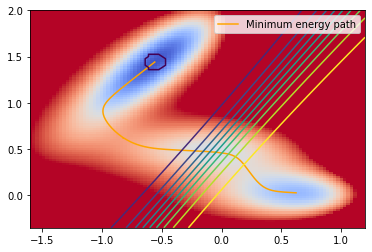

In [98]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
committor_training.plot_committor_iso_levels(ax, np.arange(0, 1, 0.1))
ax.legend()

Plot log of committor isolevels 

/tmp/ipykernel_4835/4229548764.py:11: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_4835/4229548764.py:23: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')


Text(0.5, 1.0, 'log(1 - committor) iso-levels')

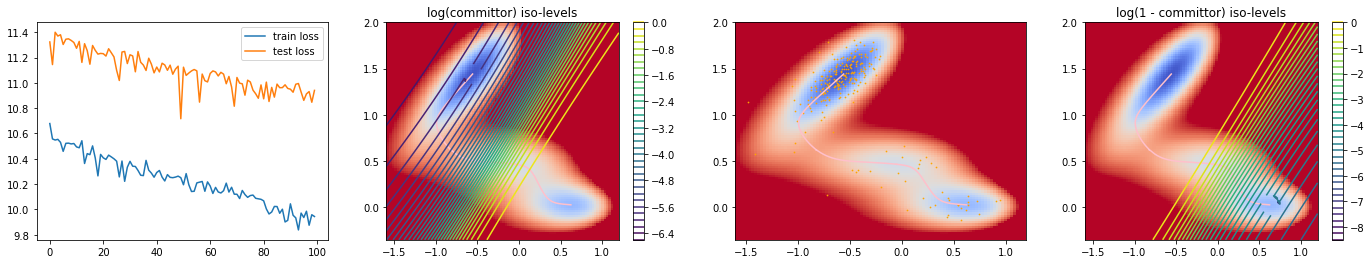

In [99]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([100, 100])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][-100:], label='train loss')
ax0.plot(loss_dict["test_loss"][-100:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='pink', label='Minimum energy path')
ax1.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='pink')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='pink', label='Minimum energy path')
ax2.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='pink')
ax2.scatter(committor_training.train_data[:, 0], committor_training.train_data[:, 1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='pink', label='Minimum energy path')
ax3.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='pink')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")

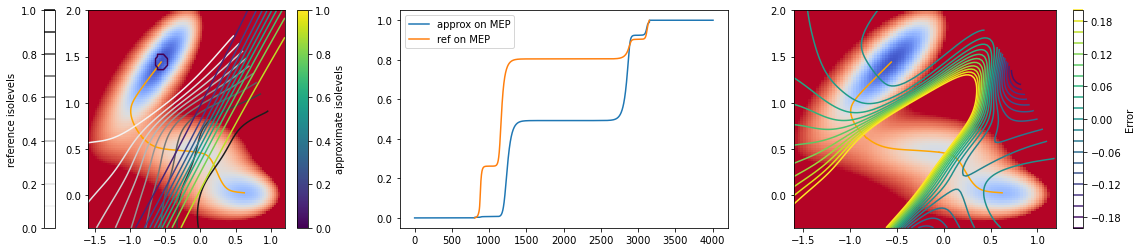

In [100]:
pts = np.loadtxt('mueller_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('mueller_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('Mueller_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

ref_committor_x2d = interp._interpolate_multikeys(x=pot.x2d[:,0], y=pot.x2d[:,1], tri_index=None, return_keys=('z',))[0].data.reshape(pot.n_bins_x, pot.n_bins_y)
committor_on_x2d = committor_training.committor_model.xi_forward(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)

## Iso-levels of the approximate and reference committor function 
fig, (ax1, ax0, ax2) = plt.subplots(1, 3, figsize=(20, 4)) 
pot.plot_potential_heat_map(ax1)
ax1.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax1.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax1, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), set_lim=False)
fig.colorbar(contour1, ax=ax1, label="reference isolevels", location='left') 
fig.colorbar(contour2, ax=ax1, label="approximate isolevels", location='right') 

## Plot the error Iso-levels 
pot.plot_potential_heat_map(ax2)
ax2.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax2.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
contour = ax2.contour(pot.x_plot, pot.y_plot, ref_committor_x2d - committor_on_x2d, np.arange(-0.2, 0.22, 0.02), cmap='viridis')
fig.colorbar(contour, ax=ax2, label="Error") 

# Plot the approximate and reference committor function along the minimum energy path
ref_committor_MEP1 = interp._interpolate_multikeys(x=pot.minimum_energy_paths[0][:, 0], y=pot.minimum_energy_paths[0][:, 1], tri_index=None, return_keys=('z',))[0]
ref_committor_MEP2 = interp._interpolate_multikeys(x=pot.minimum_energy_paths[1][:, 0], y=pot.minimum_energy_paths[1][:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP1 = committor_training.committor_model.xi_forward(pot.minimum_energy_paths[0])
committor_on_MEP2 = committor_training.committor_model.xi_forward(pot.minimum_energy_paths[1])
committor_on_MEP = np.append(committor_on_MEP1[:,0], np.flip(committor_on_MEP2[:,0]))
ref_committor_MEP = np.append(ref_committor_MEP1, np.flip(ref_committor_MEP2))
err_MEP = committor_on_MEP - ref_committor_MEP
ax0.plot(committor_on_MEP, label="approx on MEP")
ax0.plot(ref_committor_MEP, label="ref on MEP")
#ax0.plot(err_MEP, label="error on MEP")
ax0.legend()

Compute root mean squarred error of with respect to finite elements method solution on 1000 points sampled from the reactive trajectories density measure.  

In [101]:
react = np.loadtxt('react_trajs_mullerbrown.txt')

ref_committor_react = interp._interpolate_multikeys(x=react[:,0], y=react[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_react = committor_training.committor_model.xi_forward(react)[:, 0]
RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
print("RMSE react = ", RMSE)

RMSE react =  0.2923065971099432


### Generate dataset with Uniform distribution of configurations. 

In [40]:
K = 5 * 10**2    # number of short trajectories 
N = 160           # time lagg in number of delta t

In [41]:
x_ini = np.random.ranf(2*K) * (np.max(pot.x2d[:, 0]) - np.min(pot.x2d[:, 0])) + np.min(pot.x2d[:, 0])
y_ini = np.random.ranf(2*K) * (np.max(pot.x2d[:, 1]) - np.min(pot.x2d[:, 1])) + np.min(pot.x2d[:, 1])

Generate dataset in which the trajectory is stopped once R or P is reached

In [42]:
j = 0
x_0 = np.array([[x_ini[j], y_ini[j]]])
short_traj = unbiased_OL_on_MB.run(x_0, N, save_grad=False, save_gauss=True)
if pot.in_P(x_0) or pot.in_R(x_0):
    x_beg = None
else:
    x_beg = x_0
x_end = None
data_unif = np.append(x_0, short_traj["gauss_traj"][0:1, :], axis=1)
data_unif = np.append(data_unif, short_traj["x_traj"][0:1, :], axis=1)
if (pot.in_P(short_traj["x_traj"][0:1, :]) or pot.in_R(short_traj["x_traj"][0:1, :])) and x_beg is not None:
    x_end = short_traj["x_traj"][0:1, :]
for i in range(1, N):
    if x_end is not None:
        data_unif = np.append(data_unif, np.zeros([1, 2]), axis=1)
        data_unif = np.append(data_unif, x_end, axis=1)
    else:
        data_unif = np.append(data_unif, short_traj["gauss_traj"][i:i+1, :], axis=1)
        data_unif = np.append(data_unif, short_traj["x_traj"][i:i+1, :], axis=1)
        if (pot.in_P(short_traj["x_traj"][i:i+1, :]) or pot.in_R(short_traj["x_traj"][i:i+1, :])) and x_beg is not None:
            x_end = short_traj["x_traj"][i:i+1, :]
        elif not (pot.in_P(short_traj["x_traj"][i:i+1, :]) or pot.in_R(short_traj["x_traj"][i:i+1, :])): 
            x_beg = short_traj["x_traj"][i:i+1, :]
for j in range(1, 2*K):
    x_0 = np.array([[x_ini[j], y_ini[j]]])
    short_traj = unbiased_OL_on_MB.run(x_0, N, save_grad=False, save_gauss=True)
    if pot.in_P(x_0) or pot.in_R(x_0):
        x_beg = None
    else:
        x_beg = x_0
    x_end = None
    datapoint = np.append(x_0, short_traj["gauss_traj"][0:1, :], axis=1)
    datapoint = np.append(datapoint, short_traj["x_traj"][0:1, :], axis=1)
    if (pot.in_P(short_traj["x_traj"][0:1, :]) or pot.in_R(short_traj["x_traj"][0:1, :])) and x_beg is not None:
        x_end = short_traj["x_traj"][0:1, :]
    for i in range(1, N):
        if x_end is not None:
            datapoint = np.append(datapoint, np.zeros([1, 2]), axis=1)
            datapoint = np.append(datapoint, x_end, axis=1)
        else:
            datapoint = np.append(datapoint, short_traj["gauss_traj"][i:i+1, :], axis=1)
            datapoint = np.append(datapoint, short_traj["x_traj"][i:i+1, :], axis=1)
            if (pot.in_P(short_traj["x_traj"][i:i+1, :]) or pot.in_R(short_traj["x_traj"][i:i+1, :])) and x_beg is not None:
                x_end = short_traj["x_traj"][i:i+1, :]
            elif not (pot.in_P(short_traj["x_traj"][i:i+1, :]) or pot.in_R(short_traj["x_traj"][i:i+1, :])):
                x_beg = short_traj["x_traj"][i:i+1, :]
    data_unif = np.append(data_unif, datapoint, axis=0)

Generate dataset in which the trajectory is  not stopped once R or P is reached

In [43]:
j = 0
x_0 = np.array([[x_ini[j], y_ini[j]]])
short_traj = unbiased_OL_on_MB.run(x_0, N, save_grad=False, save_gauss=True)
data_unif = np.append(x_0, short_traj["gauss_traj"][0:1, :], axis=1)
data_unif = np.append(data_unif, short_traj["x_traj"][0:1, :], axis=1)
for i in range(1, N):
    data_unif = np.append(data_unif, short_traj["gauss_traj"][i:i+1, :], axis=1)
    data_unif = np.append(data_unif, short_traj["x_traj"][i:i+1, :], axis=1)
for j in range(1, 2*K):
    x_0 = np.array([[x_ini[j], y_ini[j]]])
    short_traj = unbiased_OL_on_MB.run(x_0, N, save_grad=False, save_gauss=True)
    datapoint = np.append(x_0, short_traj["gauss_traj"][0:1, :], axis=1)
    datapoint = np.append(datapoint, short_traj["x_traj"][0:1, :], axis=1)
    for i in range(1, N):
        datapoint = np.append(datapoint, short_traj["gauss_traj"][i:i+1, :], axis=1)
        datapoint = np.append(datapoint, short_traj["x_traj"][i:i+1, :], axis=1)

    data_unif = np.append(data_unif, datapoint, axis=0)

In [44]:
dataset = {"any_distrib" : data_unif, "beta" : beta, "dt" : dt}

In [45]:
del(committor)           # to restart from new model 
del(committor_training)

committor = CommittorOneDecoder([2, 5, 1], [1, 2], 0, pot)
committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dataset)

committor_training.train_test_split(train_size=K)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)

committor_training.set_optimizer('Adam', 0.001)

loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 0.0 * 10**4
loss_params["n_wait"] = 250
committor_training.set_loss_weight(loss_params)

batch_size = 10**2
max_epochs = 10000

loss_dict = committor_training.train(batch_size, max_epochs)

squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0
training ends after 3688 epochs.



Plot approximate committor iso-levels

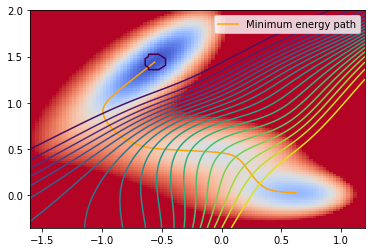

In [46]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
committor_training.plot_committor_iso_levels(ax, 20)
ax.legend()

Plot log of committor isolevels

/tmp/ipykernel_5387/2125325620.py:11: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_5387/2125325620.py:23: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')


Text(0.5, 1.0, 'log(1 - committor) iso-levels')

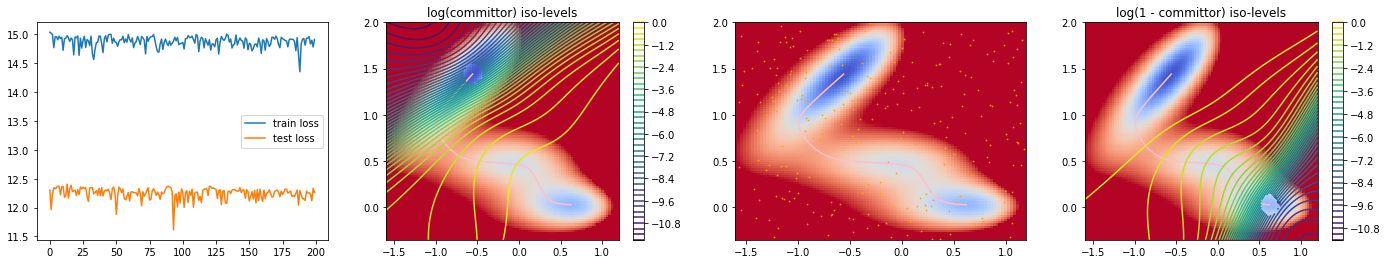

In [47]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([100, 100])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][-200:], label='train loss')
ax0.plot(loss_dict["test_loss"][-200:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='pink', label='Minimum energy path')
ax1.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='pink')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='pink', label='Minimum energy path')
ax2.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='pink')
ax2.scatter(committor_training.train_data[:, 0], committor_training.train_data[:, 1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='pink', label='Minimum energy path')
ax3.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='pink')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")

Plot figures to compare to the finite element reference

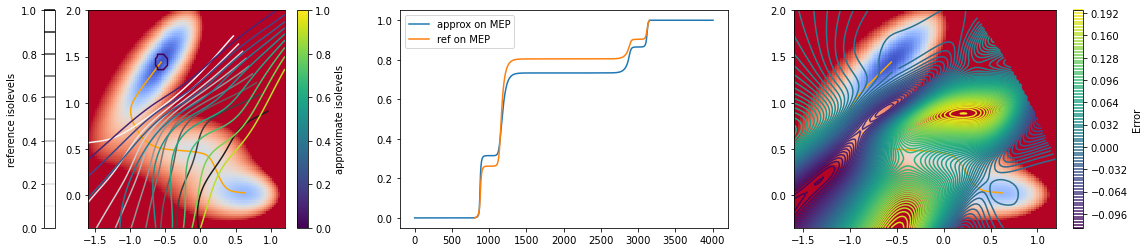

In [48]:
pts = np.loadtxt('mueller_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('mueller_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('Mueller_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

ref_committor_x2d = interp._interpolate_multikeys(x=pot.x2d[:,0], y=pot.x2d[:,1], tri_index=None, return_keys=('z',))[0].data.reshape(pot.n_bins_x, pot.n_bins_y)
committor_on_x2d = committor_training.committor_model.xi_forward(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)

## Iso-levels of the approximate and reference committor function 
fig, (ax1, ax0, ax2) = plt.subplots(1, 3, figsize=(20, 4)) 
pot.plot_potential_heat_map(ax1)
ax1.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax1.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax1, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), set_lim=False)
fig.colorbar(contour1, ax=ax1, label="reference isolevels", location='left') 
fig.colorbar(contour2, ax=ax1, label="approximate isolevels", location='right') 

## Plot the error Iso-levels 
pot.plot_potential_heat_map(ax2)
ax2.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax2.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
contour = ax2.contour(pot.x_plot, pot.y_plot, ref_committor_x2d - committor_on_x2d, 100, cmap='viridis')
fig.colorbar(contour, ax=ax2, label="Error") 

# Plot the approximate and reference committor function along the minimum energy path
ref_committor_MEP1 = interp._interpolate_multikeys(x=pot.minimum_energy_paths[0][:, 0], y=pot.minimum_energy_paths[0][:, 1], tri_index=None, return_keys=('z',))[0]
ref_committor_MEP2 = interp._interpolate_multikeys(x=pot.minimum_energy_paths[1][:, 0], y=pot.minimum_energy_paths[1][:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP1 = committor_training.committor_model.xi_forward(pot.minimum_energy_paths[0])
committor_on_MEP2 = committor_training.committor_model.xi_forward(pot.minimum_energy_paths[1])
committor_on_MEP = np.append(committor_on_MEP1[:,0], np.flip(committor_on_MEP2[:,0]))
ref_committor_MEP = np.append(ref_committor_MEP1, np.flip(ref_committor_MEP2))
err_MEP = committor_on_MEP - ref_committor_MEP
ax0.plot(committor_on_MEP, label="approx on MEP")
ax0.plot(ref_committor_MEP, label="ref on MEP")
#ax0.plot(err_MEP, label="error on MEP2")
ax0.legend()

Compute root mean squarred error of with respect to finite elements method solution on 1000 points sampled from the reactive trajectories density measure.

In [49]:
react = np.loadtxt('react_trajs_mullerbrown.txt')

ref_committor_react = interp._interpolate_multikeys(x=react[:,0], y=react[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_react = committor_training.committor_model.xi_forward(react)[:, 0]
RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
print("RMSE react = ", RMSE)

RMSE react =  0.06069679729228783


In [50]:
committor_training.penalization_on_points()

tensor(8.8619e-07, grad_fn=<MeanBackward0>)

### Generate dataset distributed according to the distribtion of reactive trajectories. 

Load a big sample of points distributed according to reactive trajectories probability distribution 

In [74]:
react_approx_density = np.loadtxt("mullerbrown_react_dens.txt")

In [75]:
K = 5 * 10**2    # number o short trajectories 
N = 160            # time lagg in number of delta t

In [76]:
indices = np.random.choice(len(react_approx_density), size=2*K)

Generate dataset in which the trajectory is stopped once R or P is reached

In [77]:
x_0 = react_approx_density[indices[0]:indices[0]+1]
short_traj = unbiased_OL_on_MB.run(x_0, N, save_grad=False, save_gauss=True)
if pot.in_P(x_0) or pot.in_R(x_0):
    x_beg = None
else:
    x_beg = x_0
x_end = None
data_reac = np.append(x_0, short_traj["gauss_traj"][0:1, :], axis=1)
data_reac = np.append(data_reac, short_traj["x_traj"][0:1, :], axis=1)
if (pot.in_P(short_traj["x_traj"][0:1, :]) or pot.in_R(short_traj["x_traj"][0:1, :])) and x_beg is not None:
    x_end = short_traj["x_traj"][0:1, :]
for i in range(1, N):
    if x_end is not None:
        data_reac = np.append(data_reac, np.zeros([1, 2]), axis=1)
        data_reac = np.append(data_reac, x_end, axis=1)
    else:
        data_reac = np.append(data_reac, short_traj["gauss_traj"][i:i+1, :], axis=1)
        data_reac = np.append(data_reac, short_traj["x_traj"][i:i+1, :], axis=1)
        if (pot.in_P(short_traj["x_traj"][i:i+1, :]) or pot.in_R(short_traj["x_traj"][i:i+1, :])) and x_beg is not None:
            x_end = short_traj["x_traj"][i:i+1, :]
        elif not (pot.in_P(short_traj["x_traj"][i:i+1, :]) or pot.in_R(short_traj["x_traj"][i:i+1, :])):
            x_beg = short_traj["x_traj"][i:i+1, :]
for j in range(1, 2*K):
    x_0 = react_approx_density[indices[j]:indices[j]+1]
    short_traj = unbiased_OL_on_MB.run(x_0, N, save_grad=False, save_gauss=True)
    if pot.in_P(x_0) or pot.in_R(x_0):
        x_beg = None
    else:
        x_beg = x_0
    x_end = None
    datapoint = np.append(x_0, short_traj["gauss_traj"][0:1, :], axis=1)
    datapoint = np.append(datapoint, short_traj["x_traj"][0:1, :], axis=1)
    if (pot.in_P(short_traj["x_traj"][0:1, :]) or pot.in_R(short_traj["x_traj"][0:1, :])) and x_beg is not None:
        x_end = short_traj["x_traj"][0:1, :]
    for i in range(1, N):
        if x_end is not None:
            datapoint = np.append(datapoint, np.zeros([1, 2]), axis=1)
            datapoint = np.append(datapoint, x_end, axis=1)
        else:
            datapoint = np.append(datapoint, short_traj["gauss_traj"][i:i+1, :], axis=1)
            datapoint = np.append(datapoint, short_traj["x_traj"][i:i+1, :], axis=1)
            if (pot.in_P(short_traj["x_traj"][i:i+1, :]) or pot.in_R(short_traj["x_traj"][i:i+1, :])) and x_beg is not None:
                x_end = short_traj["x_traj"][i:i+1, :]
            elif not (pot.in_P(short_traj["x_traj"][i:i+1, :]) or pot.in_R(short_traj["x_traj"][i:i+1, :])): 
                x_beg = short_traj["x_traj"][i:i+1, :]
    data_reac = np.append(data_reac, datapoint, axis=0)

Generate dataset for which trajectories are not stopped when R or P is reached

In [78]:
x_0 = react_approx_density[indices[0]:indices[0]+1]
short_traj = unbiased_OL_on_MB.run(x_0, N, save_grad=False, save_gauss=True)
data_reac = np.append(x_0, short_traj["gauss_traj"][0:1, :], axis=1)
data_reac = np.append(data_reac, short_traj["x_traj"][0:1, :], axis=1)
for i in range(1, N):
    data_reac = np.append(data_reac, short_traj["gauss_traj"][i:i+1, :], axis=1)
    data_reac = np.append(data_reac, short_traj["x_traj"][i:i+1, :], axis=1)
for j in range(1, 2*K):
    x_0 = react_approx_density[indices[j]:indices[j]+1]
    short_traj = unbiased_OL_on_MB.run(x_0, N, save_grad=False, save_gauss=True)
    datapoint = np.append(x_0, short_traj["gauss_traj"][0:1, :], axis=1)
    datapoint = np.append(datapoint, short_traj["x_traj"][0:1, :], axis=1)
    for i in range(1, N):
        datapoint = np.append(datapoint, short_traj["gauss_traj"][i:i+1, :], axis=1)
        datapoint = np.append(datapoint, short_traj["x_traj"][i:i+1, :], axis=1)

    data_reac = np.append(data_reac, datapoint, axis=0)

In [79]:
dataset = {"any_distrib" : data_reac, "beta" : beta, "dt" : dt}

In [ ]:
del(committor)           # to restart from new model 
del(committor_training)

committor = CommittorOneDecoder([2, 5, 1], [1, 2], 0, pot)
committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dataset)

committor_training.train_test_split(train_size=K)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)

committor_training.set_optimizer('Adam', 0.001)

loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 0.0 * 10**4
loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)

batch_size = 10**2
max_epochs = 10000

loss_dict = committor_training.train(batch_size, max_epochs)

squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


Plot approximate committor iso-levels

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
committor_training.plot_committor_iso_levels(ax, 20)
ax.legend()

Plot log of committor isolevels

In [ ]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([100, 100])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][-200:], label='train loss')
ax0.plot(loss_dict["test_loss"][-200:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='pink', label='Minimum energy path')
ax1.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='pink')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='pink', label='Minimum energy path')
ax2.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='pink')
ax2.scatter(committor_training.train_data[:, 0], committor_training.train_data[:, 1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='pink', label='Minimum energy path')
ax3.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='pink')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")

Plot figures to compare to the finite element reference

In [ ]:
pts = np.loadtxt('mueller_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('mueller_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('Mueller_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

ref_committor_x2d = interp._interpolate_multikeys(x=pot.x2d[:,0], y=pot.x2d[:,1], tri_index=None, return_keys=('z',))[0].data.reshape(pot.n_bins_x, pot.n_bins_y)
committor_on_x2d = committor_training.committor_model.xi_forward(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)

## Iso-levels of the approximate and reference committor function 
fig, (ax1, ax0, ax2) = plt.subplots(1, 3, figsize=(20, 4)) 
pot.plot_potential_heat_map(ax1)
ax1.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax1.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax1, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), set_lim=False)
fig.colorbar(contour1, ax=ax1, label="reference isolevels", location='left') 
fig.colorbar(contour2, ax=ax1, label="approximate isolevels", location='right') 

## Plot the error Iso-levels 
pot.plot_potential_heat_map(ax2)
ax2.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax2.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
contour = ax2.contour(pot.x_plot, pot.y_plot, ref_committor_x2d - committor_on_x2d, 100, cmap='viridis')
fig.colorbar(contour, ax=ax2, label="Error") 

# Plot the approximate and reference committor function along the minimum energy path
ref_committor_MEP1 = interp._interpolate_multikeys(x=pot.minimum_energy_paths[0][:, 0], y=pot.minimum_energy_paths[0][:, 1], tri_index=None, return_keys=('z',))[0]
ref_committor_MEP2 = interp._interpolate_multikeys(x=pot.minimum_energy_paths[1][:, 0], y=pot.minimum_energy_paths[1][:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP1 = committor_training.committor_model.xi_forward(pot.minimum_energy_paths[0])
committor_on_MEP2 = committor_training.committor_model.xi_forward(pot.minimum_energy_paths[1])
committor_on_MEP = np.append(committor_on_MEP1[:,0], np.flip(committor_on_MEP2[:,0]))
ref_committor_MEP = np.append(ref_committor_MEP1, np.flip(ref_committor_MEP2))
err_MEP = committor_on_MEP - ref_committor_MEP
ax0.plot(committor_on_MEP, label="approx on MEP")
ax0.plot(ref_committor_MEP, label="ref on MEP")
#ax0.plot(err_MEP, label="error on MEP2")
ax0.legend()

Compute root mean squarred error of with respect to finite elements method solution on 1000 points sampled from the reactive trajectories density measure.

In [ ]:
react = np.loadtxt('react_trajs_mullerbrown.txt')

ref_committor_react = interp._interpolate_multikeys(x=react[:,0], y=react[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_react = committor_training.committor_model.xi_forward(react)[:, 0]
RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
print("RMSE react = ", RMSE)

In [ ]:
committor_training.penalization_on_points()